# Earthquake_real
> Non-Euclidean geometry

- toc:true
- branch: master
- badges: true
- comments: false
- author: 최서연
- categories: [Graph Laplacian, PCA]

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import networkx as nx
import folium

In [2]:
df=pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/earthquakes-23k.csv')

- t = Year
- x = Latitude
- y = Longitude
- f = Magnitude

##### 1. 데이터 정의

In [3]:
_df = df.assign(Year=list(map(lambda x: x.split('/')[-1], df.Date))).query('Year>="2000"').reset_index().iloc[:,1:]
_df

,Date,Latitude,Longitude,Magnitude,Year
0,01/01/2000,-60.7220,153.6700,6.0,2000
1,01/02/2000,-17.9430,-178.4760,5.5,2000
2,01/02/2000,51.4470,-175.5580,5.8,2000
3,01/02/2000,-20.7710,-174.2360,5.8,2000
4,01/05/2000,-20.9640,-174.0970,5.6,2000
...,...,...,...,...,...
8739,12/28/2016,38.3917,-118.8941,5.6,2016
8740,12/28/2016,38.3777,-118.8957,5.5,2016
8741,12/28/2016,36.9179,140.4262,5.9,2016
8742,12/29/2016,-9.0283,118.6639,6.3,2016


In [4]:
__df = df.assign(Year=list(map(lambda x: x.split('/')[-1], df.Date))).query('Year>="2015"').reset_index().iloc[:,1:]
__df

,Date,Latitude,Longitude,Magnitude,Year
0,01/02/2015,6.5739,60.3653,5.5,2015
1,01/05/2015,-43.0546,171.2364,5.6,2015
2,01/06/2015,55.2049,163.2446,5.6,2015
3,01/07/2015,5.9045,-82.6576,6.5,2015
4,01/08/2015,-61.6118,161.3346,5.7,2015
...,...,...,...,...,...
910,12/28/2016,38.3917,-118.8941,5.6,2016
911,12/28/2016,38.3777,-118.8957,5.5,2016
912,12/28/2016,36.9179,140.4262,5.9,2016
913,12/29/2016,-9.0283,118.6639,6.3,2016


##### 2. $f(x) = y + \epsilon$ 정의
- $y$ = Magnitude,  지진 규모로 정의

In [5]:
f_true = _df.loc[:,"Magnitude"]

In [6]:
f = f_true + np.random.normal(scale=0.2,size=len(f_true))

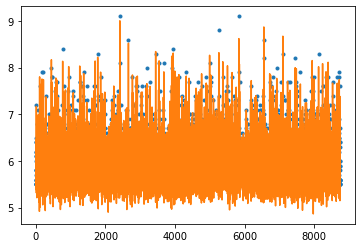

In [7]:
plt.plot(f_true,'.')
plt.plot(f,'-')

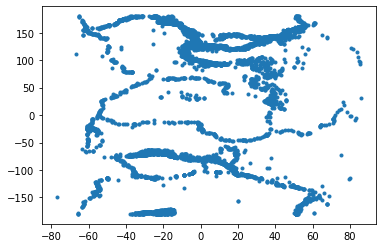

In [8]:
plt.plot( _df.Latitude,_df.Longitude,'.')

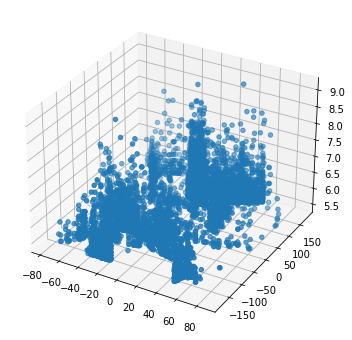

In [9]:
fig = plt.figure(figsize=(9, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(_df.Latitude, _df.Longitude, _df.Magnitude)
#ax.scatter(_df.Latitude, _df.Longitude, 0)

In [10]:
from mpl_toolkits.basemap import Basemap

In [11]:
#collapse

from itertools import chain

def draw_map(m, scale=0.2):
    # draw a shaded-relief image
    m.shadedrelief(scale=scale)
    
    # lats and longs are returned as a dictionary
    lats = m.drawparallels(np.linspace(-90, 90, 13))
    lons = m.drawmeridians(np.linspace(-180, 180, 13))

    # keys contain the plt.Line2D instances
    lat_lines = chain(*(tup[1][0] for tup in lats.items()))
    lon_lines = chain(*(tup[1][0] for tup in lons.items()))
    all_lines = chain(lat_lines, lon_lines)
    
    # cycle through these lines and set the desired style
    for line in all_lines:
        line.set(linestyle='-', alpha=0.3, color='w')

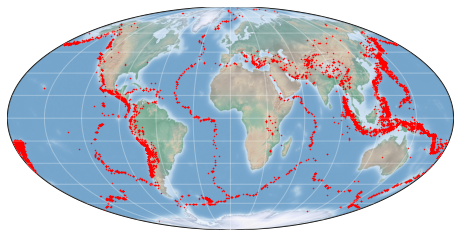

In [12]:
#collapse

fig = plt.figure(figsize=(8, 6), edgecolor='w')
m = Basemap(projection='moll', resolution=None,
            lat_0=0, lon_0=0)
lon = _df.Longitude
lat = _df.Latitude
x,y = m(lon, lat)
m.plot(x, y, 'r.', markersize=1)
draw_map(m)

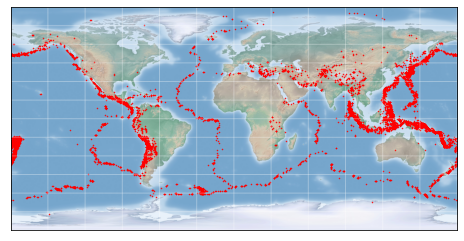

In [13]:
#collapse

fig = plt.figure(figsize=(8, 6), edgecolor='w')
m = Basemap(projection='cyl', resolution=None,
            llcrnrlat=-90, urcrnrlat=90,
            llcrnrlon=-180, urcrnrlon=180, )
lon = _df.Longitude
lat = _df.Latitude
x,y = m(lon, lat)
m.plot(x, y, 'r.', markersize=1)
draw_map(m)

In [15]:
#collapse
lst=[_df.assign(Year=list(map(lambda x: x.split('/')[-1], _df.Date))).\
groupby('Year').\
pipe(list)[i][1].iloc[:,[1,2,3]].\
to_numpy().tolist() for i in range(2016-2000)]

In [16]:
#collapse
from folium import plugins 
data=(np.random.normal(size=(100,3)) + np.array([[28,77,5]])).tolist() # (좌표,weight)를 의미함, 그리고 numpy는 list가 될 수 없기 때문에 tolist 옵션 사용
m=folium.Map([28,77],zoom_start=6,scrollWheelZoom=False)
plugins.HeatMap(data).add_to(m) 

In [17]:
m=folium.Map(scrollWheelZoom=False)
plugins.HeatMapWithTime(lst,radius=5,index=list(range(2000,2016))).add_to(m)
m

##### 3. $(x_i,y_i)$와 $(x_j,y_j)$ 사이의 유클리드 거리 정의
- $x$ = Latitude, 위도로 정의
- $y$ = Longitude, 경도로 정의
- 지진의 영향이 주변에만 끼치는 것을 고려하여 경도, 위도의 차이가 90도 이내인 경우만 거리 계산

$$dist((x_i,y_i),(x_j,y_j)) = \sqrt{((x_j-x_i)^2-(y_j-y_i)^2}$$

In [156]:
def dist(i,j):
    if abs( _df.Latitude[j] - _df.Latitude[i] ) >= 90: 
        return 100000  
    if abs( _df.Longitude[j] - _df.Longitude[i] ) >= 90: 
        return 100000
    else:
        return np.sqrt( ( ( _df.Latitude[j] - _df.Latitude[i] )**2) + ( ( _df.Longitude[j] - _df.Longitude[i])**2) )

##### 4. 거리를 이용한 $W_{i,j}$ 행렬 정의
- a weighted adjacency matrix $W$
- 동일한 지점 상의 거리는 0이 되어 $W_{i,j}$가 1이 될 것이다(대각행렬은 모두 1)
- 연결강도로 생각

$$W_{i,j}=\begin{cases}{exp(-\frac{[dist(i,j)]^2}{2\theta^2})} & \quad \text{if } dist(i,j) \leq κ \\ 0 & \quad \text{otherwise} \end{cases}$$

In [266]:
def weight(i,j,theta=150,kappa=10000):
    return np.exp( -np.abs(dist(i,j))**2 / (2*theta**2) ) if dist(i,j) <= kappa else 0

In [267]:
W = np.array([[weight(i,j) for i in range(len(__df))] for j in range(len(__df))])

In [268]:
W.round(3)

array([[1.   , 0.   , 0.   , ..., 0.85 , 0.922, 0.   ],
       [0.   , 1.   , 0.806, ..., 0.   , 0.   , 0.849],
       [0.   , 0.806, 1.   , ..., 0.   , 0.   , 0.   ],
       ...,
       [0.85 , 0.   , 0.   , ..., 1.   , 0.944, 0.   ],
       [0.922, 0.   , 0.   , ..., 0.944, 1.   , 0.   ],
       [0.   , 0.849, 0.   , ..., 0.   , 0.   , 1.   ]])

(array([[458.,   0.,  60., ...,  88.,  99.,  89.],
        [725.,  23.,  37., ...,   7.,  31.,  77.],
        [733.,  19.,  38., ...,   7.,  42.,  59.],
        ...,
        [389.,  64.,  31., ...,  11.,  50., 241.],
        [334.,  95.,  16., ...,   6.,  19., 290.],
        [679.,  19.,  27., ...,   5.,  20., 113.]]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 915 BarContainer objects>)

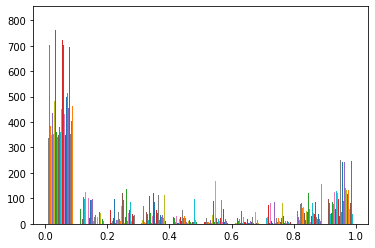

In [269]:
plt.hist(W)

https://stackoverflow.com/questions/29572623/plot-networkx-graph-from-adjacency-matrix-in-csv-file

그래프

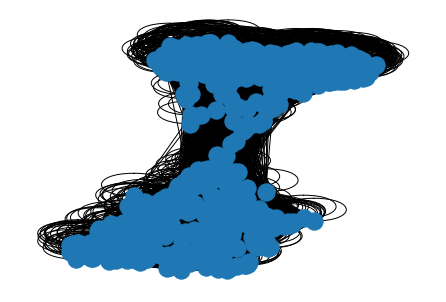

In [270]:
nx.draw(nx.Graph(W))
# 저장하고 싶으면
# plt.show(
# plt.savefig("networkGraph.png")

##### 5. $W_{i,j}$ 행렬을 이용한 차수 행렬 정의
- $D$ = Degree Matrix

In [271]:
D = np.diag(W.sum(axis=1))

In [272]:
D

array([[322.14602588,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  0.        , 128.3656061 ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        , 118.58131732, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  0.        ,   0.        ,   0.        , ..., 351.60113341,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
        386.69975059,   0.        ],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        , 160.25364536]])

##### 6. Graph Laplacian matrix 정의
- $L = D - W$

In [273]:
L = D - W

In [274]:
L

array([[321.14602588,   0.        ,   0.        , ...,  -0.84967604,
         -0.92225199,   0.        ],
       [  0.        , 127.3656061 ,  -0.80575682, ...,   0.        ,
          0.        ,  -0.84907962],
       [  0.        ,  -0.80575682, 117.58131732, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [ -0.84967604,   0.        ,   0.        , ..., 350.60113341,
         -0.94418167,   0.        ],
       [ -0.92225199,   0.        ,   0.        , ...,  -0.94418167,
        385.69975059,   0.        ],
       [  0.        ,  -0.84907962,   0.        , ...,   0.        ,
          0.        , 159.25364536]])

##### 7. 고유값 분해
- ${\bf L} = {\boldsymbol\Psi} {\boldsymbol\Lambda} {\boldsymbol\Psi}^\top$

In [275]:
λ, Ψ = np.linalg.eig(L)

In [276]:
Λ = np.diag(λ)

##### 8. $f \times \Psi \times \Psi^\top $

In [277]:
def p(i):
    return sum((f @ np.outer(Ψ[:,i], Ψ[:,i]))*(f @ np.outer(Ψ[:,i], Ψ[:,i])))

In [278]:
p_sum = np.array([p(i) for i in range(len(__df))])

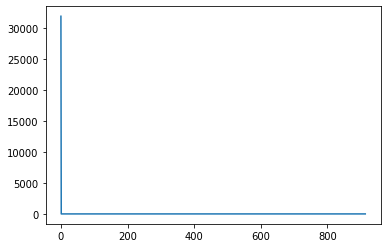

In [279]:
plt.plot(p_sum)

In [280]:
np.argsort(p_sum)[0:10]

array([376, 788,  51, 871, 350, 270, 609, 766, 807, 288])

In [281]:
p(0)/sum(p_sum)

0.9930702952274133

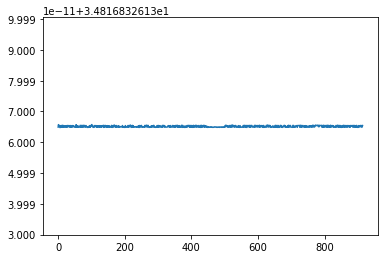

In [284]:
plt.plot( (f @ np.outer( Ψ[:,[0]], Ψ[:,[0]])) * ( f @ np.outer( Ψ[:,[0]], Ψ[:,[0]])))

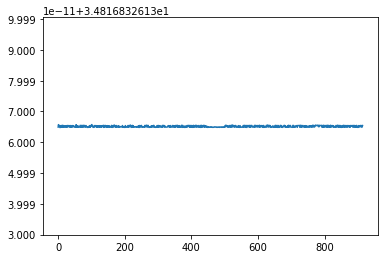

In [282]:
plt.plot( (f @ np.outer( Ψ[:,np.argsort(p_sum)[-1]], Ψ[:,np.argsort(p_sum)[-1]])) * ( f @ np.outer( Ψ[:,np.argsort(p_sum)[-1]], Ψ[:,np.argsort(p_sum)[-1]])))

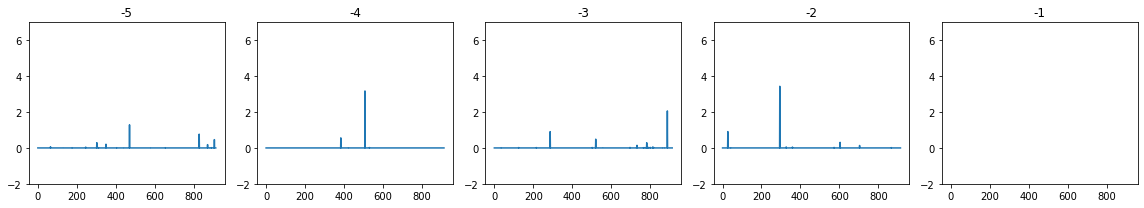

In [283]:
fig,ax =plt.subplots(1,5)
k=-5
for i in range(5):
    ax[i].plot((f @ np.outer( Ψ[:,np.argsort(p_sum)[k]], Ψ[:,np.argsort(p_sum)[k]])) * ( f @ np.outer( Ψ[:,np.argsort(p_sum)[k]], Ψ[:,np.argsort(p_sum)[k]])))
    ax[i].set_ylim([-2,7])
    ax[i].set_title(k)
    k=k+1
fig.set_figwidth(16)            
fig.set_figheight(3)
fig.tight_layout()        

##### 9. PCA

평균을 나타내는 component

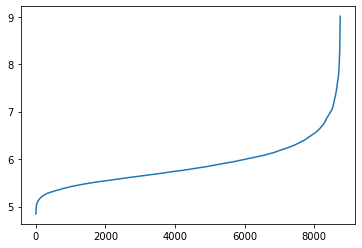

In [34]:
plt.plot(f[np.argsort(f)].reset_index().iloc[:,1])

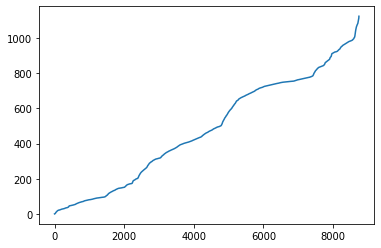

In [35]:
plt.plot(λ[np.argsort(λ)])

component 추정

In [36]:
np.argsort(λ)[0:20]

array([123, 138, 137, 136, 135, 134, 133, 132, 131, 671, 506, 130, 129,
       128, 672, 678, 679, 127, 505, 504])

In [37]:
np.argsort(λ)[-10:-1]

array([9, 8, 7, 6, 5, 4, 3, 2, 1])

In [38]:
np.mean(f)

5.878409446231422

In [39]:
np.mean(f @ np.outer(Ψ[:,np.argsort(λ)[0]], Ψ[:,np.argsort(λ)[0]]))

5.878409446230752

In [40]:
comphat1=f @ np.outer(Ψ[:,np.argsort(λ)[0]], Ψ[:,np.argsort(λ)[0]])

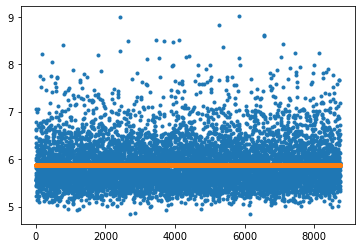

In [41]:
plt.plot(f,'.')
plt.plot(comphat1,'.')

component1 빼고 component2 추정

In [42]:
comphat2 =  f @ np.outer(Ψ[:,np.argsort(λ)[1]], Ψ[:,np.argsort(λ)[1]]) 

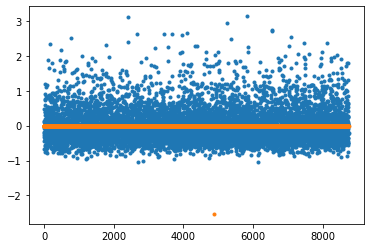

In [43]:
plt.plot(f-comphat1,'.')
plt.plot(comphat2,'.')

In [44]:
comphat3 =  f @ np.outer(Ψ[:,np.argsort(λ)[2]], Ψ[:,np.argsort(λ)[2]]) 

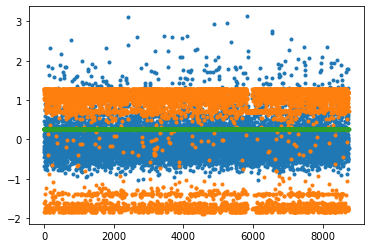

In [45]:
plt.plot(f-comphat1-comphat2,'.')
plt.plot(comphat3,'.')
plt.plot([np.mean(comphat3)]*len(f), '.')

In [46]:
comphat4 =  f @ np.outer(Ψ[:,np.argsort(λ)[3]], Ψ[:,np.argsort(λ)[3]]) 

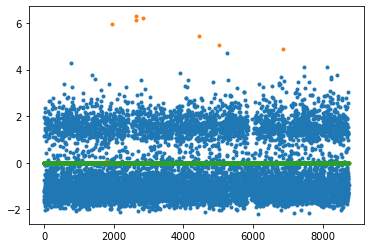

In [47]:
plt.plot(f-comphat1-comphat2-comphat3,'.')
plt.plot(comphat4, '.')
plt.plot([np.mean(comphat4)]*len(f), '.')

(3.0, 10.0)

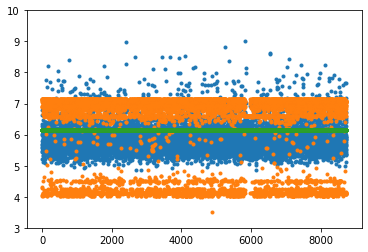

In [48]:
plt.plot(f,'.')
plt.plot(comphat1 + comphat2 + comphat3 + comphat4,'.')
plt.plot([np.mean(comphat1 + comphat2 + comphat3 + comphat4)]*len(f), '.')
plt.ylim(3,10)

In [49]:
f_hat = comphat1 + comphat2 + comphat3 + comphat4

---

ref: https://jakevdp.github.io/PythonDataScienceHandbook/04.13-geographic-data-with-basemap.html

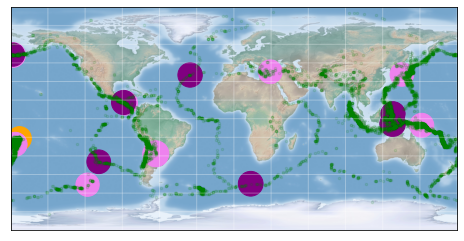

In [62]:
fig = plt.figure(figsize=(8, 6), edgecolor='w')
m = Basemap(projection='cyl', resolution=None,
            llcrnrlat=-90, urcrnrlat=90,
            llcrnrlon=-180, urcrnrlon=180, )
lon = _df.Longitude
lat = _df.Latitude
x,y = m(lon, lat)
scale = 100
m.plot(x, y, 'g.', markersize=5, alpha=0.1)
#m.plot(x[np.argsort(λ)[1:10]], y[np.argsort(λ)[1:10]], 'r-', markersize=10)
m.scatter(x[np.argsort(λ)[0]], y[np.argsort(λ)[0]], color='orange', s=abs(f[np.argsort(λ)[0]])*scale)
m.scatter(x[np.argsort(λ)[1:10]], y[np.argsort(λ)[1:10]], color='violet', s=abs(f[np.argsort(λ)[1:10]])*scale)
m.scatter(x[np.argsort(λ)[11:20]], y[np.argsort(λ)[11:20]], color='purple', s=abs(f[np.argsort(λ)[11:20]])*scale)
draw_map(m)

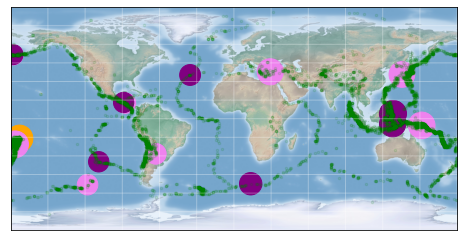

In [51]:
fig = plt.figure(figsize=(8, 6), edgecolor='w')
m = Basemap(projection='cyl', resolution=None,
            llcrnrlat=-90, urcrnrlat=90,
            llcrnrlon=-180, urcrnrlon=180, )
lon = _df.Longitude
lat = _df.Latitude
x,y = m(lon, lat)
scale = 100
m.plot(x, y, 'g.', markersize=5, alpha=0.1)
#m.plot(x[np.argsort(λ)[1:10]], y[np.argsort(λ)[1:10]], 'r-', markersize=10)
m.scatter(x[np.argsort(λ)[0]], y[np.argsort(λ)[0]], color='orange', s=abs(f_hat[np.argsort(λ)[0]])*scale)
m.scatter(x[np.argsort(λ)[1:10]], y[np.argsort(λ)[1:10]], color='violet', s=abs(f_hat[np.argsort(λ)[1:10]])*scale)
m.scatter(x[np.argsort(λ)[11:20]], y[np.argsort(λ)[11:20]], color='purple', s=abs(f_hat[np.argsort(λ)[11:20]])*scale)
draw_map(m)

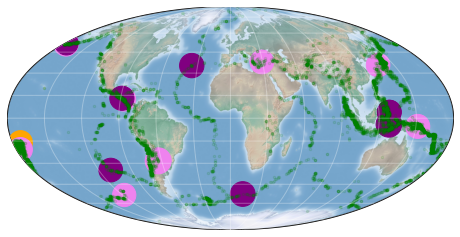

In [52]:
fig = plt.figure(figsize=(8, 6), edgecolor='w')
m = Basemap(projection='moll', resolution=None,
            lat_0=0, lon_0=0)
lon = _df.Longitude
lat = _df.Latitude
x,y = m(lon, lat)
scale = 100
m.plot(x, y, 'g.', markersize=5, alpha=0.1)
#m.plot(x[np.argsort(λ)[1:10]], y[np.argsort(λ)[1:10]], 'r-', markersize=10)
m.scatter(x[np.argsort(λ)[0]], y[np.argsort(λ)[0]], color='orange', s=abs(f[np.argsort(λ)[0]])*scale)
m.scatter(x[np.argsort(λ)[1:10]], y[np.argsort(λ)[1:10]], color='violet', s=abs(f[np.argsort(λ)[1:10]])*scale)
m.scatter(x[np.argsort(λ)[11:20]], y[np.argsort(λ)[11:20]], color='purple', s=abs(f[np.argsort(λ)[11:20]])*scale)
draw_map(m)